# Credit Card Fraud Classification
> Name: Sharun Garg  
Student ID: 200493338

## 1. Importing the important libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

### Reading the data

In [2]:
data = pd.read_excel('CreditCardDataset.xlsx')
data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
16354,58496,-0.769923,1.692726,1.040596,2.314980,0.771871,1.194325,0.828797,-0.818222,-2.042708,...,0.742252,-0.280914,-0.400340,-1.004544,0.496995,0.351555,0.021805,0.031332,77.52,0
17224,60465,-1.134453,0.636843,2.457241,1.317848,0.605755,0.143546,0.242076,0.371466,-1.315582,...,0.328508,0.683118,-0.114294,0.203942,0.035426,-0.090987,0.057247,0.102961,23.27,0
84,294,-0.745116,0.446440,1.714154,-0.146626,-0.244287,-0.963058,0.566537,-0.044998,0.274475,...,-0.149227,-0.440704,0.088860,0.708177,-0.570540,0.036992,-0.041732,0.182178,33.33,0
5232,33730,-0.297540,1.024087,1.379766,0.773351,0.508075,-0.312819,0.924556,-0.219051,-0.444746,...,0.094090,0.655241,-0.162420,0.097649,-0.279416,-0.317369,0.270330,0.001101,8.39,0
16739,59361,-1.062598,0.163040,0.897494,-1.912990,0.028494,-0.120700,-0.113100,0.452667,-1.384991,...,0.367302,1.162845,0.119364,-0.288533,-0.212082,-0.306161,-0.001868,-0.134910,1.00,0


### Splitting the data into feature set and target set

In [3]:
features = data.drop('Class', axis = 1)
target = data['Class']

### Data Shape

In [4]:
print(f'Data shape: {data.shape}')
print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

Data shape: (57355, 31)
Features shape: (57355, 30)
Target shape: (57355,)


> **Our data has 57355 entries with 31 columns. 30 of them are features and the last column is of class**

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,57355.0,94577.357074,47505.713234,2.000000,53943.500000,84641.000000,139140.000000,172777.000000
V1,57355.0,-0.029092,2.061391,-36.802320,-0.927615,0.015980,1.314129,2.454930
V2,57355.0,0.030156,1.711228,-63.344698,-0.588747,0.071801,0.815413,22.057729
V3,57355.0,-0.055749,1.733364,-48.325589,-0.922554,0.168619,1.019384,3.940337
V4,57355.0,0.035521,1.484621,-5.519697,-0.839400,-0.005637,0.764271,16.715537
V5,57355.0,-0.022664,1.508300,-113.743307,-0.692157,-0.055913,0.607021,28.762671
V6,57355.0,-0.006869,1.361819,-19.996349,-0.774796,-0.276163,0.387408,73.301626
V7,57355.0,-0.032448,1.504317,-43.557242,-0.558211,0.035797,0.562758,120.589494
V8,57355.0,0.006142,1.334058,-73.216718,-0.207145,0.024380,0.333358,20.007208
V9,57355.0,-0.017667,1.131679,-13.434066,-0.651869,-0.053373,0.599522,10.348407


> Most of our features in data are looking scaled with just **Amount** and **Time** column not scaled. We'll scale these columns as well.

In [6]:
data.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

> **There are no null values in data and our data is complete.**

**The quality variable analysis**

In [7]:
target.value_counts()

0    56863
1      492
Name: Class, dtype: int64

> Most of the data points are for class are of Class 0, around 99%, and only few data points for Class 0 indicating skewness in data.

<AxesSubplot:>

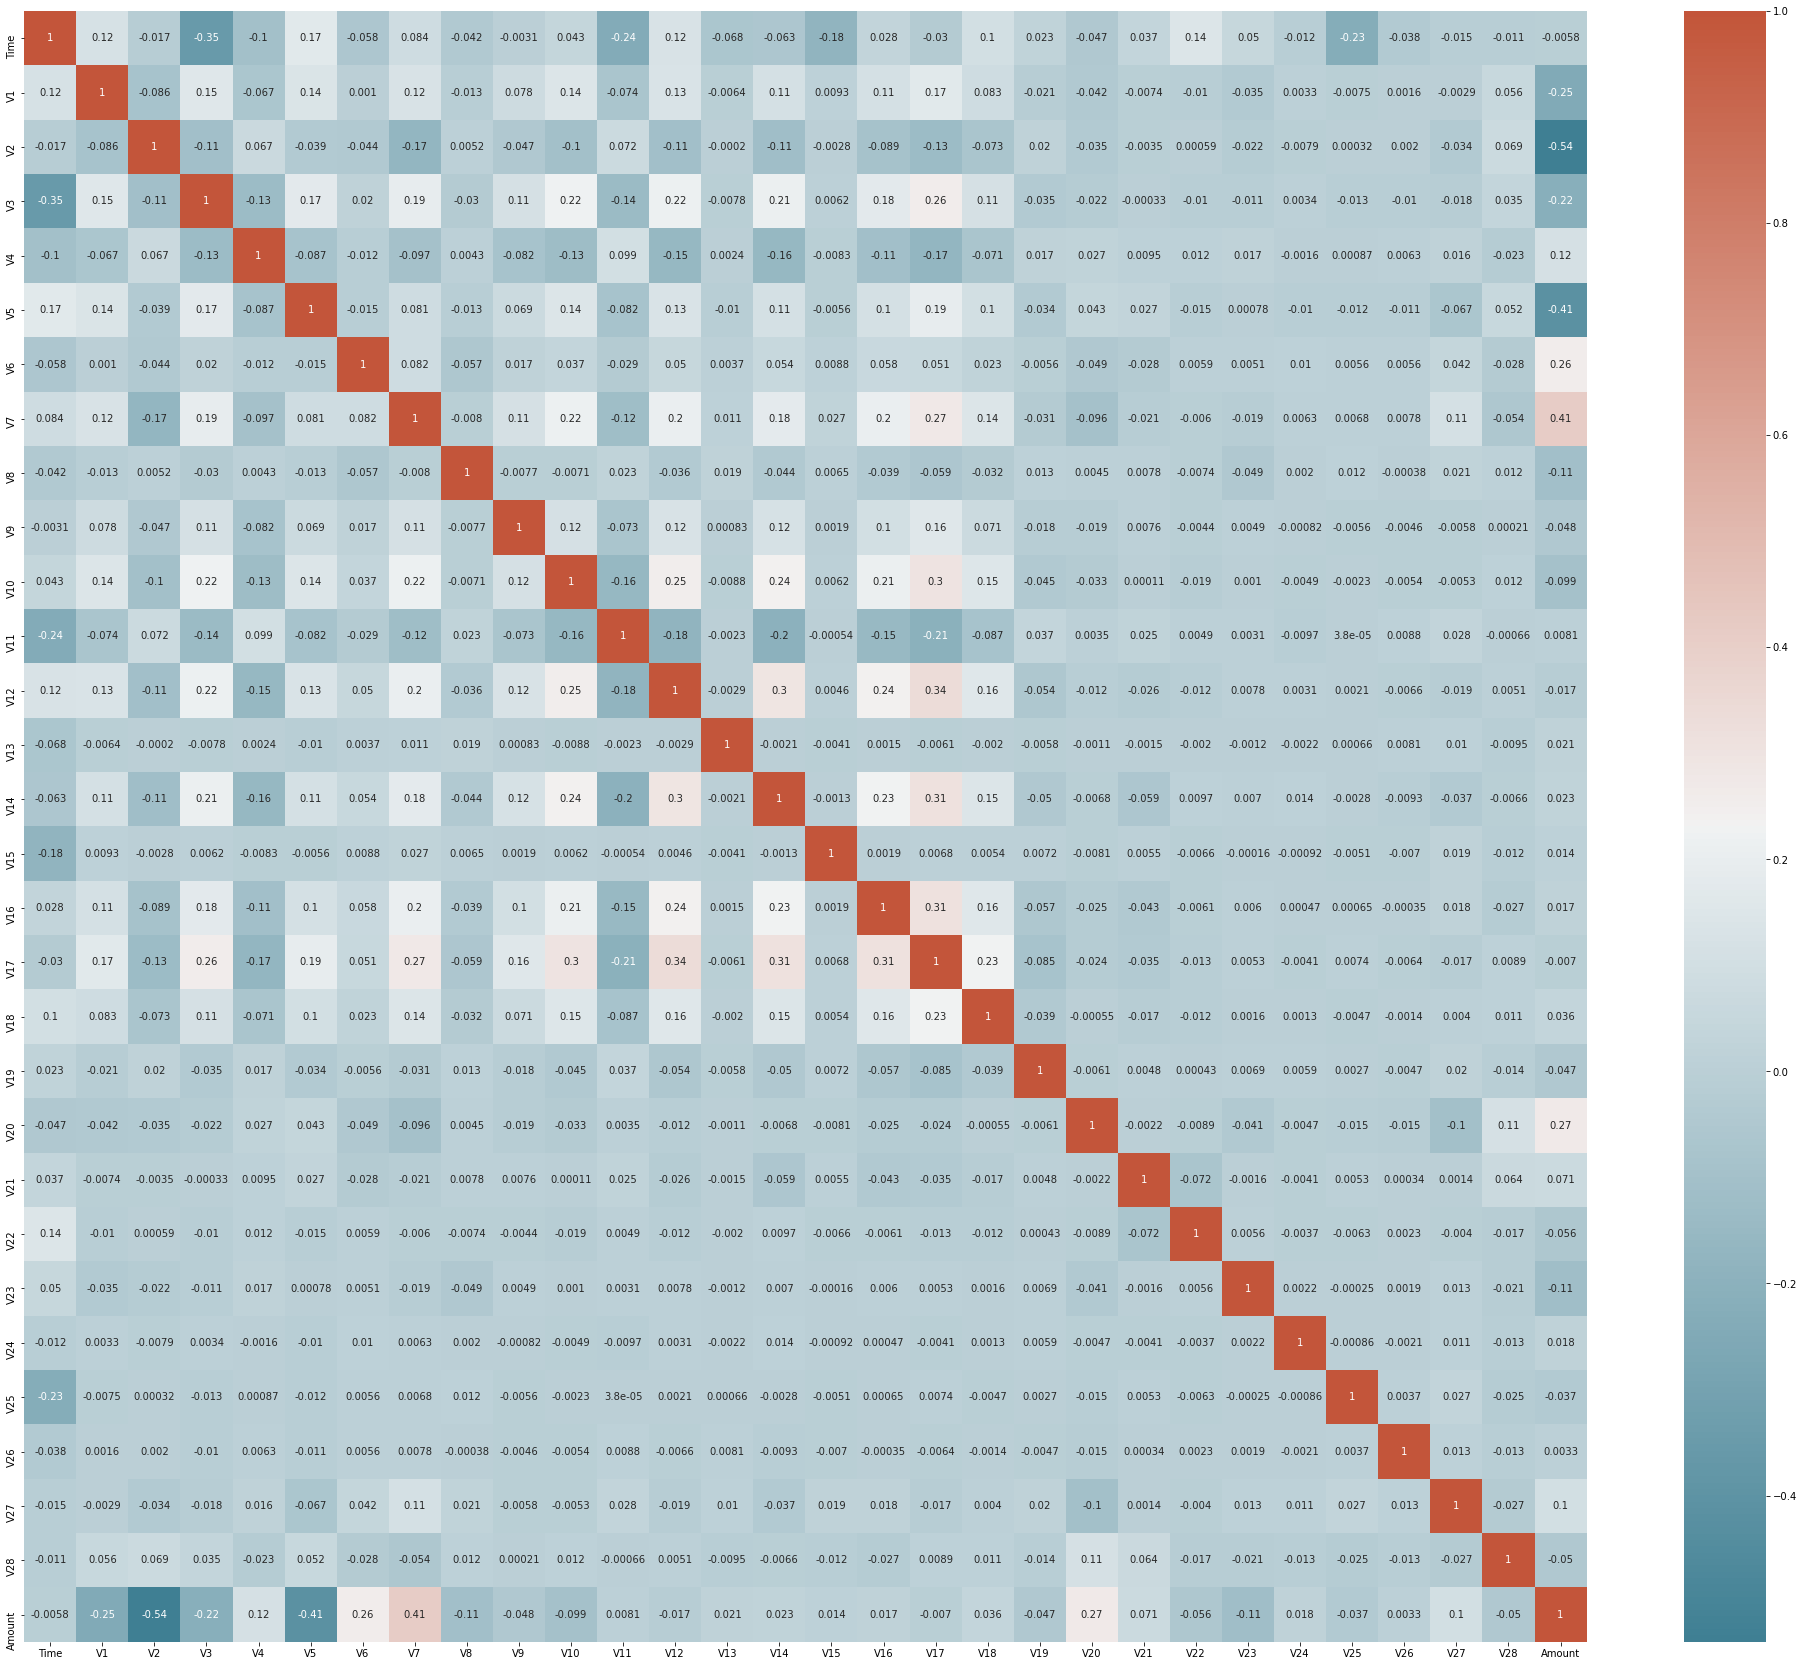

In [8]:
corr = features.corr()
plt.subplots(figsize=(35,30))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))


> **Observation:**  
> There isn't much correlation between any features so we won't be removing any columns from our dataset.

/Users/sharungarg/miniforge3/envs/tf_nn/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


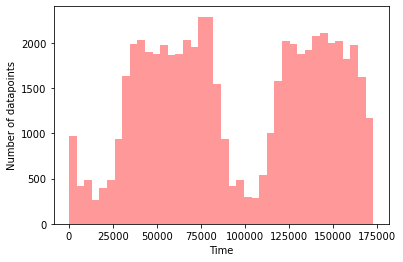

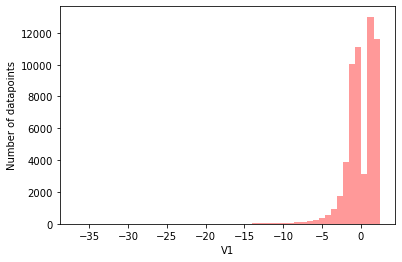

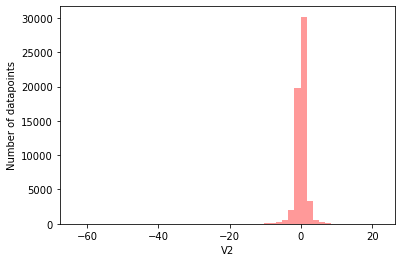

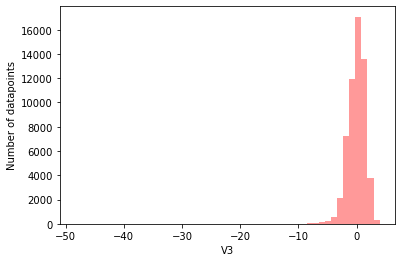

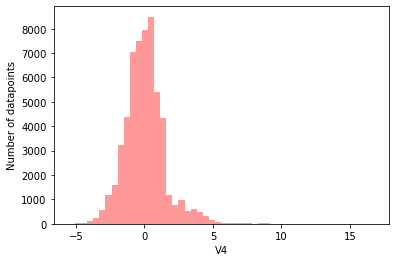

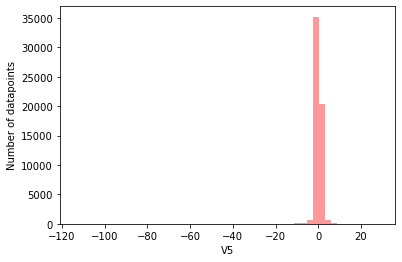

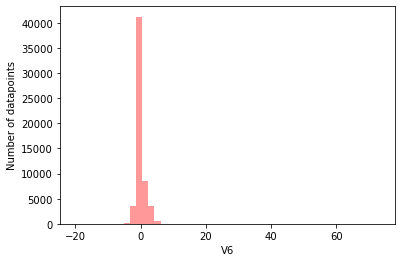

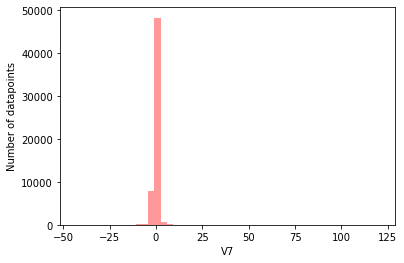

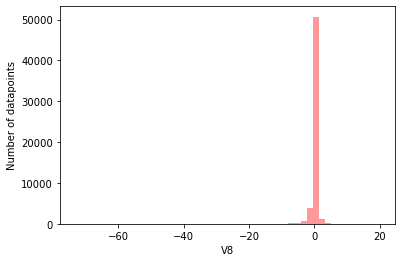

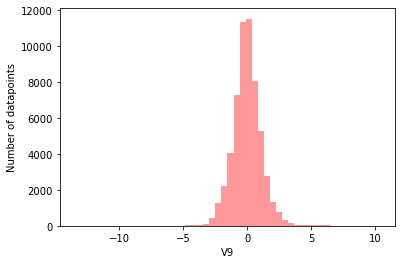

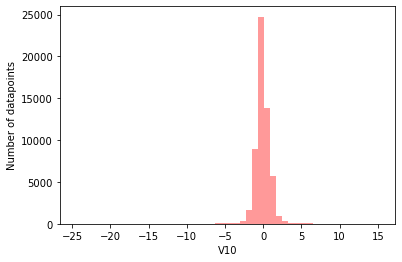

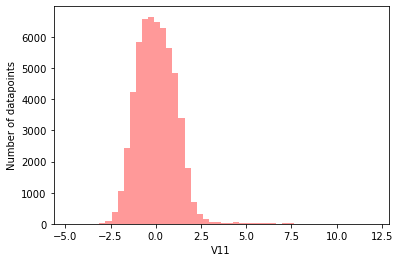

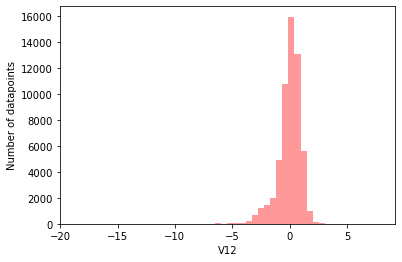

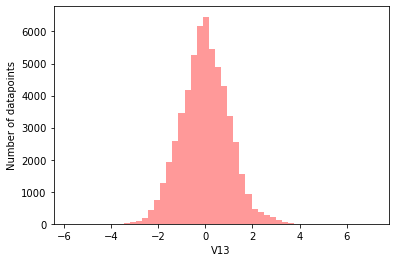

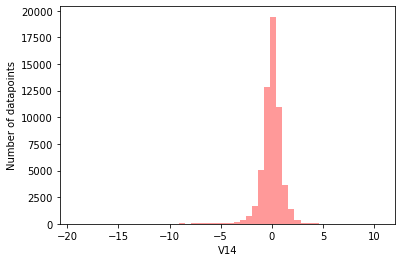

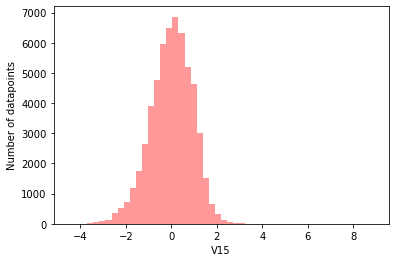

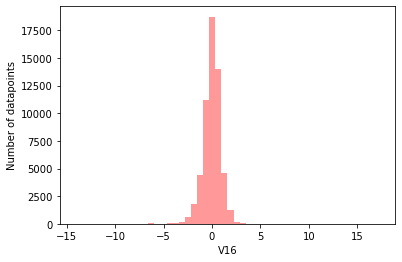

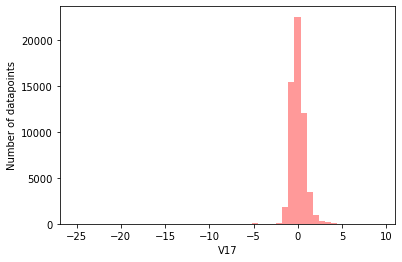

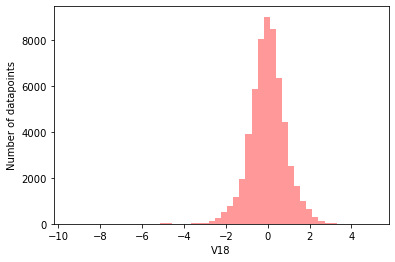

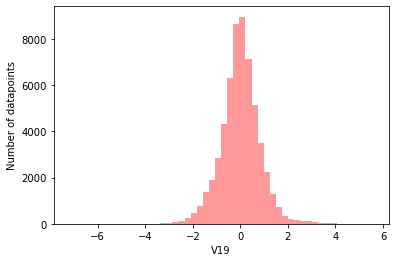

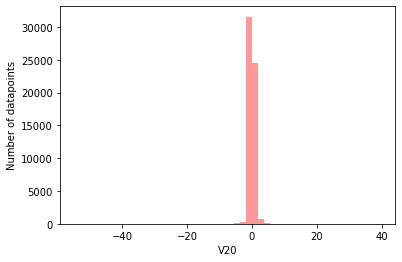

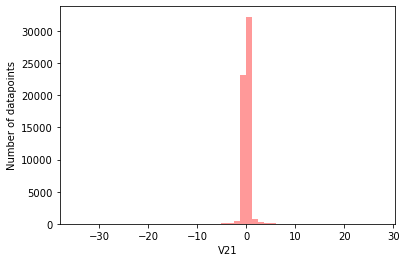

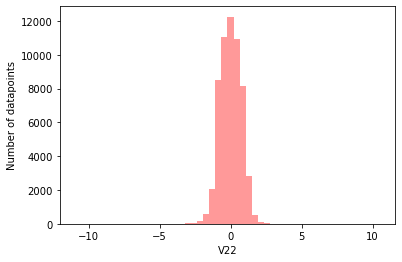

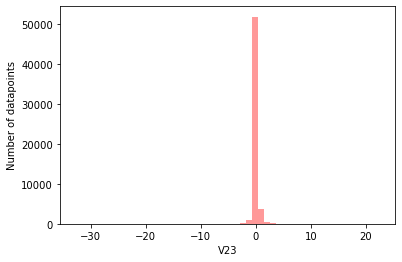

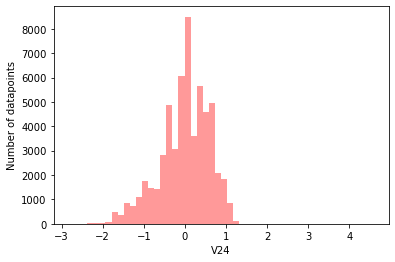

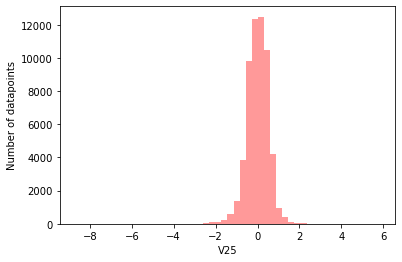

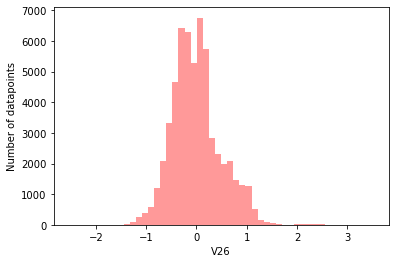

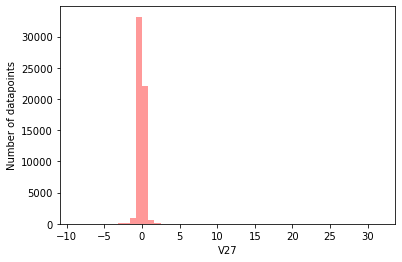

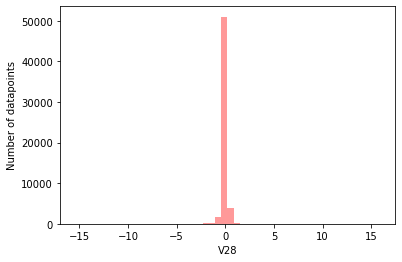

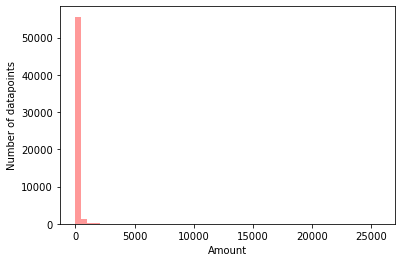

In [9]:
def histograms(attribute):
    sns.distplot(a=data[attribute], kde=False, color='r')
    plt.ylabel("Number of datapoints")
    plt.show()

for col in features.columns:
    histograms(col)

> **Observation:** 
> We can see that most of our datapoints are looking scaled and is varifiable from plots. The **Time** and **Amount** columns will also be scaled for training purposes.

**Scaling Time and Amount Columns**

In [10]:
std_sc = StandardScaler()
scaled_time = std_sc.fit_transform(features['Time'].values.reshape(-1,1))
scaled_amount = std_sc.fit_transform(features['Amount'].values.reshape(-1,1))
features.drop(['Time', 'Amount'], axis = 1, inplace=True)
features.insert(0, 'Scaled_Time', scaled_time)
features.insert(1, 'Scaled_Amount', scaled_amount)
features.head(5)

,Scaled_Time,Scaled_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.990838,-0.067392,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
1,-1.990838,-0.304677,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080
2,-1.990733,-0.171830,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,...,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339
3,-1.990649,-0.219416,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,...,-0.982916,-0.153197,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293
4,-1.990628,-0.260598,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,...,0.432535,0.263451,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394


### Splitting the data into train and test set.

In [11]:
# Split into train+val and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [12]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Counting the class distribution

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "fraud": 0,
        "non_fraud": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['non_fraud'] += 1
        elif i == 1: 
            count_dict['fraud'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

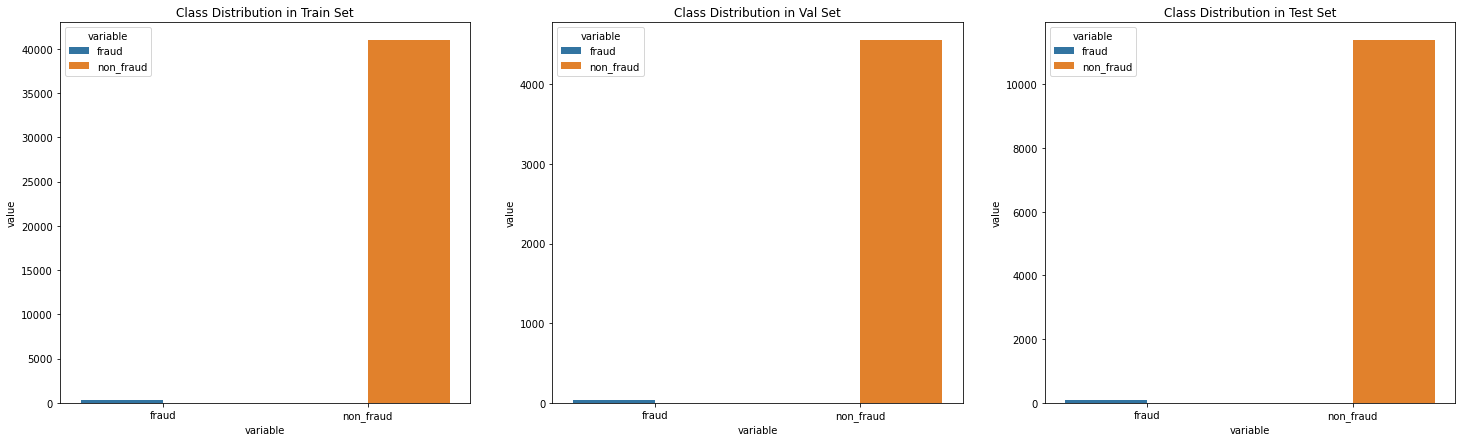

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

> As we can see that there's a lot of skewness in data but it is uniform amongst all our splits

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [16]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([2.8169e-03, 2.4426e-05])


In [18]:
class_weights_all = class_weights[target_list]

## Handling skewness in data with weighted Sampler

In [19]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [20]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = len(features.columns)
NUM_CLASSES = 2

In [21]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [22]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

## PyTorch Multiclass Classifier

In [23]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=30, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [26]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        # get the inputs
        X_train_batch, y_train_batch = X_train_batch, y_train_batch
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            # get the inputs
            X_val_batch, y_val_batch = X_val_batch, y_val_batch
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    # print statistics
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.02103 | Val Loss: 0.02536 | Train Acc: 98.830| Val Acc: 99.150
Epoch 002: | Train Loss: 0.00057 | Val Loss: 0.02940 | Train Acc: 99.194| Val Acc: 99.150
Epoch 003: | Train Loss: 0.00037 | Val Loss: 0.03755 | Train Acc: 99.411| Val Acc: 99.150
Epoch 004: | Train Loss: 0.00037 | Val Loss: 0.03187 | Train Acc: 99.203| Val Acc: 99.150
Epoch 005: | Train Loss: 0.00030 | Val Loss: 0.02858 | Train Acc: 99.393| Val Acc: 99.150
Epoch 006: | Train Loss: 0.00036 | Val Loss: 0.05110 | Train Acc: 99.173| Val Acc: 99.150
Epoch 007: | Train Loss: 0.00024 | Val Loss: 0.03711 | Train Acc: 99.345| Val Acc: 99.324
Epoch 008: | Train Loss: 0.00025 | Val Loss: 0.02113 | Train Acc: 99.642| Val Acc: 99.782
Epoch 009: | Train Loss: 0.00032 | Val Loss: 0.02537 | Train Acc: 99.326| Val Acc: 99.150
Epoch 010: | Train Loss: 0.00033 | Val Loss: 0.02961 | Train Acc: 99.249| Val Acc: 99.150
Epoch 011: | Train Loss: 0.00029 | Val Loss: 0.02552 | Train Acc: 99.242| Val Acc: 99.150
Epoch 012:

Epoch 093: | Train Loss: 0.00012 | Val Loss: 0.04292 | Train Acc: 99.800| Val Acc: 99.695
Epoch 094: | Train Loss: 0.00007 | Val Loss: 0.03849 | Train Acc: 99.847| Val Acc: 99.782
Epoch 095: | Train Loss: 0.00012 | Val Loss: 0.05594 | Train Acc: 99.826| Val Acc: 99.412
Epoch 096: | Train Loss: 0.00015 | Val Loss: 0.05186 | Train Acc: 99.705| Val Acc: 99.695
Epoch 097: | Train Loss: 0.00010 | Val Loss: 0.04527 | Train Acc: 99.805| Val Acc: 99.760
Epoch 098: | Train Loss: 0.00009 | Val Loss: 0.04401 | Train Acc: 99.821| Val Acc: 99.782
Epoch 099: | Train Loss: 0.00010 | Val Loss: 0.04206 | Train Acc: 99.798| Val Acc: 99.782
Epoch 100: | Train Loss: 0.00009 | Val Loss: 0.03927 | Train Acc: 99.837| Val Acc: 99.782


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

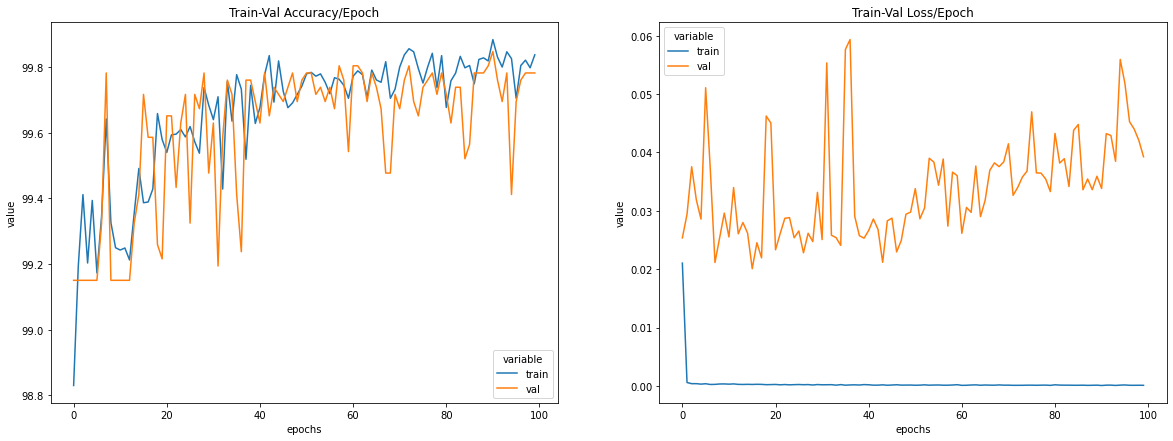

In [27]:
# Results dataframe
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Visualize dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

> #### OBSERVATION:  
The Classirier did decent with accuracy in above 99% for both training and validation set, with higher variance in validation set as compared to training set, indicating overfitting. The loss also for training set is almost zero and high variance in validation set.
&nbsp;  
&nbsp;

In [28]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

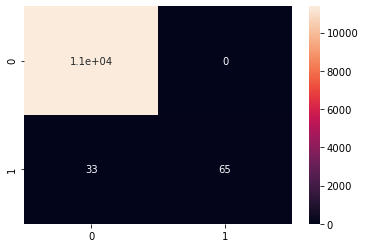

In [29]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

> #### OBSERVATION:  
As we can see the performance metrics for class 0 are higher as compared to Class 1 as the datapoints for class 0 was high with a lot of examples to learn patterns for our model. For class 1, the True positives are double as compared to False positives, therefore, the model did learn some pattern in identifying the Class 1.
&nbsp;  
&nbsp;  

**Checking performance metrics for each class**

In [30]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11373
           1       1.00      0.66      0.80        98

    accuracy                           1.00     11471
   macro avg       1.00      0.83      0.90     11471
weighted avg       1.00      1.00      1.00     11471



## Conclusion:  
- The model did well very high accuracy of over 99% and low loss.
- The Precision for both the classes in 100%, with class 0 having recall of 100% as well, but class 1 having low recall.
- The F1 score indicating the quantity precision and recall together is 1 for class 0, so our model is great in generalising against class 0, and the F1 score for class 1 is comparitively lower at 0.8